In [1]:
%load_ext autoreload
%autoreload 2
import sys
import logging
from pathlib import Path
import configparser

from lmfit import fit_report
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt

from gaussian_model import SingleGaussian, DoubleGaussian
from image import Image
from res import config

constants = configparser.ConfigParser()
constants.read('res/constants.ini')

log = logging.getLogger('psfphot')
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logging.getLogger('parso.python.diff').disabled = True # turn off IPython debugging
logging.getLogger('matplotlib').setLevel(logging.WARNING)


Analyze star nearby Pluto and Charon to estimate $\sigma_x$, $\sigma_y$, and $\theta$

In [ ]:
dim = 60
for index in config.indices:
    log.info(index)
    path = f'{config.data_folder}/{config.date}/pluto{index}.fits'
    entry = constants[f'{config.date}{index}']
    image = Image(path).subimage(entry['ref_star_x'], entry['ref_star_y'], dim, dim)
    image.write_fits(f'res/images/refstar{index}.fits')
    psfinit = {}
    psfinit['a'] = 500
    psfinit['bg'] = 500
    psfinit['xc'] =  dim/2
    psfinit['yc'] = dim/2
    psfinit['theta'] = 0
    psfinit['sigma_x'] = 5
    psfinit['sigma_y'] = 5

    psf = SingleGaussian(psfinit, image)
    psf.set_vary(['a', 'bg', 'xc', 'yc', 'theta', 'sigma_x', 'sigma_y'])
    psf.set_limits('a', 100, 5000)
    psf.set_limits('bg', 100, 1500)
    psf.set_limits('xc', 0, dim)
    psf.set_limits('yc', 0, dim)
    psf.set_limits('sigma_x', 0, 50)
    psf.set_limits('sigma_y', 0, 50)
    params = psf.run_minimizer()
    log.info(psf.get_result())
    log.info(fit_report(params, show_correl=False))

    entry['sigma_x'] = str(params['sigma_x'].value)
    entry['sigma_y'] = str(params['sigma_y'].value)
    entry['theta'] = str(params['theta'].value*180/np.pi % 360)
    constants.write(Path('res/constants.ini').open('w'))
    


Use above values to fit Pluto and Charon psf

In [ ]:
dim = 60
for index in config.indices:
    log.info(index)
    path = f'{config.data_folder}/{config.date}/pluto{index}.fits'
    entry = constants[f'{config.date}{index}']
    image = Image(path).subimage(entry['pluto_charon_x'], entry['pluto_charon_y'], dim, dim)
    image.write_fits(f'res/subimages/pluto_charon{index}.fits')
    psfinit = {}
    psfinit['a_p'] = 250
    psfinit['rel_flux'] = 0.18501
    psfinit['bg'] = 500
    psfinit['x_p'] =  dim/2
    psfinit['y_p'] = dim/2
    psfinit['dx'] = 3
    psfinit['dy'] = 0
    psfinit['theta'] = float(entry['theta']) * np.pi/180
    psfinit['sigma_x'] = float(entry['sigma_x'])
    psfinit['sigma_y'] = float(entry['sigma_y'])

    psf = DoubleGaussian(psfinit, image)
    psf.set_vary(['a_p', 'bg', 'x_p', 'y_p', 'dx', 'dy'])
    psf.set_limits('a_p', 100, 5000)
    psf.set_limits('bg', 100, 1500)
    psf.set_limits('x_p', 0, dim)
    psf.set_limits('y_p', 0, dim)
    psf.set_limits('dx', -8.5, 8.5)
    psf.set_limits('dy', -8.5, 8.5)
    params = psf.run_minimizer()
    log.info(psf.get_result())
    log.info(fit_report(params, show_correl=False))

    entry['dx'] = str(params['dx'].value)
    entry['dy'] = str(params['dy'].value)
    constants.write(Path('res/constants.ini').open('w'))
    


Plot pluto and charon results

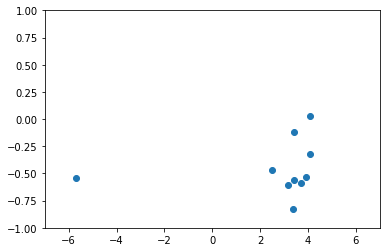

In [4]:
dx = [float(constants[f'{config.date}{index}']['dx']) for index in config.indices]
dy = [float(constants[f'{config.date}{index}']['dy']) for index in config.indices]
%matplotlib inline
plt.figure()
plt.title('Charon relative to Pluto (0,0)')
plt.xlim((-7,7))
plt.ylim((-1,1))
plt.scatter(dx, dy)
plt.show()